In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
from image import *
import cv2
#from model import CSRNet
#import torch
%matplotlib inline

C:\Users\Baptiste\AppData\Local\Temp\ipykernel_1832\340327316.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
#set the root to the Shanghai dataset you download
root = 'ShanghaiTech_Crowd_Counting_Dataset/'

In [4]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]
path_sets

['ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\\images',
 'ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\\images']

In [5]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [6]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    print(mat)
    gt = mat["image_info"][0,0][0,0][0]
    break

ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_1.jpg
{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Oct 23 13:18:27 2015', '__version__': '1.0', '__globals__': [], 'image_info': array([[array([[(array([[ 29.6225116 , 472.92022152],
                       [ 54.35533603, 454.96602305],
                       [ 51.79045053, 460.46220626],
                       ...,
                       [597.89732076, 688.27900015],
                       [965.77518336, 638.44693908],
                       [166.9965574 , 628.1873971 ]]), array([[1546]], dtype=uint16))]],
              dtype=[('location', 'O'), ('number', 'O')])                               ]],
      dtype=object)}


In [7]:
import scipy.spatial

for i,img_path in enumerate(img_paths):
    print(i, img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    try:
        with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k
    except:
        print("Already created")

0 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_1.jpg
(768, 1024)
generate density...


C:\Users\Baptiste\AppData\Local\Temp\ipykernel_24564\4051122479.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')

KeyboardInterrupt



In [16]:
#FOR VITS

import scipy.spatial

for i,img_path in enumerate(img_paths):
    print(i, img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    height, width = img.shape[0],img.shape[1]
    print(height, width)
    
    #resized fo vit
    
    img = cv2.resize(img, (512,512))
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    #gt[1]=height
    #gt[0]=width
    
    for i in range(0,len(gt)):
        #print(gt[i])
        #print(gt[i][1]/height*512,gt[i][0]/width*512)
        if int(gt[i][1]/height*512)<img.shape[0] and int(gt[i][0]/width*512)<img.shape[1]:
            k[int(gt[i][1]/height*512),int(gt[i][0]/width*512)]=1
        else:
            print(gt[i])
    k = gaussian_filter_density(k)
    try:
        with h5py.File(img_path.replace('.jpg','.h5').replace('images','new_gt'), 'w') as hf:
            hf['density'] = k
    except:
        print("Already created")

0 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_1.jpg
768 1024
(512, 512)
generate density...


C:\Users\Baptiste\AppData\Local\Temp\ipykernel_24564\4051122479.py:24: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')


done.
Already created
1 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_10.jpg
683 1024
(512, 512)
generate density...
done.
2 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_100.jpg
654 1024
[1090.05345903   49.48475775]
[1061.11910197  339.86169824]
(512, 512)
generate density...
done.
3 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_101.jpg
768 1024
(512, 512)
generate density...
done.
4 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_102.jpg
768 1024
[1049.31293706  576.05819181]
(512, 512)
generate density...
done.
5 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_103.jpg
400 400
(512, 512)
generate density...
done.
6 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_104.jpg
405 540
(512, 512)
generate density...
done.
7 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_105.jpg
632 990
[994.95054945 322.92857143]
(512, 512)
g

done.
48 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_142.jpg
455 670
(512, 512)
generate density...
done.
49 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_143.jpg
605 1024
(512, 512)
generate density...
done.
50 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_144.jpg
768 1024
(512, 512)
generate density...
done.
51 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_145.jpg
561 1024
(512, 512)
generate density...
done.
52 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_146.jpg
680 1024
(512, 512)
generate density...
done.
53 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_147.jpg
768 1024
(512, 512)
generate density...
done.
54 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_148.jpg
680 1024
(512, 512)
generate density...
done.
55 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_149.jpg
683 1024
(512, 51

done.
109 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_198.jpg
415 650
(512, 512)
generate density...
done.
110 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_199.jpg
505 1024
[1024.76283854  439.30008136]
(512, 512)
generate density...
done.
111 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_2.jpg
713 1024
(512, 512)
generate density...
done.
112 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_20.jpg
688 1024
(512, 512)
generate density...
done.
113 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_200.jpg
500 760
(512, 512)
generate density...
done.
114 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_201.jpg
530 800
(512, 512)
generate density...
done.
115 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_202.jpg
530 800
(512, 512)
generate density...
done.
116 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\imag

done.
170 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_252.jpg
400 600
(512, 512)
generate density...
done.
171 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_253.jpg
686 1024
(512, 512)
generate density...
done.
172 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_254.jpg
683 1024
(512, 512)
generate density...
done.
173 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_255.jpg
701 749
(512, 512)
generate density...
done.
174 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_256.jpg
576 1024
(512, 512)
generate density...
done.
175 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_257.jpg
768 1024
(512, 512)
generate density...
done.
176 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_258.jpg
768 1024
(512, 512)
generate density...
done.
177 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_259.jpg
338 506
(5

done.
231 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_37.jpg
683 1024
(512, 512)
generate density...
done.
232 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_38.jpg
566 1024
(512, 512)
generate density...
done.
233 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_39.jpg
683 1024
(512, 512)
generate density...
done.
234 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_4.jpg
746 1024
(512, 512)
generate density...
done.
235 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_40.jpg
388 576
(512, 512)
generate density...
done.
236 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_41.jpg
683 1024
(512, 512)
generate density...
done.
237 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_42.jpg
667 1000
(512, 512)
generate density...
done.
238 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_43.jpg
683 1024
(512, 512

done.
293 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_93.jpg
351 620
(512, 512)
generate density...
done.
294 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_94.jpg
370 1024
[1024.17092241  277.90428238]
[1024.17092241  158.26818515]
(512, 512)
generate density...
done.
295 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_95.jpg
600 800
(512, 512)
generate density...
done.
296 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_96.jpg
530 1024
[1070.84004603  310.67681305]
(512, 512)
generate density...
done.
297 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_97.jpg
366 550
(512, 512)
generate density...
done.
298 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_98.jpg
512 1024
(512, 512)
generate density...
done.
299 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_99.jpg
688 1024
(512, 512)
generate density...
done.
300 Shangha

done.
355 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_149.jpg
749 1024
(512, 512)
generate density...
done.
356 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_15.jpg
333 500
(512, 512)
generate density...
done.
357 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_150.jpg
428 652
(512, 512)
generate density...
done.
358 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_151.jpg
437 624
(512, 512)
generate density...
done.
359 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_152.jpg
709 1024
(512, 512)
generate density...
done.
360 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_153.jpg
400 600
[600.2002997  216.68381618]
(512, 512)
generate density...
done.
361 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_154.jpg
324 1024
[474.74076862 324.74583041]
(512, 512)
generate density...
done.
362 ShanghaiTech_Crowd_Counting_Dataset/part_A_

done.
418 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_41.jpg
768 1024
[1090.89220183  611.91972477]
(512, 512)
generate density...
done.
419 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_42.jpg
768 1024
[1074.07492355  611.83639144]
(512, 512)
generate density...
done.
420 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_43.jpg
683 1024
(512, 512)
generate density...
done.
421 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_44.jpg
767 1024
(512, 512)
generate density...
done.
422 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_45.jpg
671 827
[874.15825688 348.69667431]
(512, 512)
generate density...
done.
423 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_46.jpg
680 1024
[1036.13557154  326.76067146]
(512, 512)
generate density...
done.
424 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_47.jpg
350 600
(512, 512)
generate densit

done.
479 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_97.jpg
669 1000
[1043.95925926  611.27222222]
(512, 512)
generate density...
done.
480 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_98.jpg
373 561
(512, 512)
generate density...
done.
481 ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data\images\IMG_99.jpg
480 640
(512, 512)
generate density...
done.


In [17]:
965.77518336/1024*512

482.88759168

In [18]:
n=100
print(img_paths[n])

ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\images\IMG_19.jpg


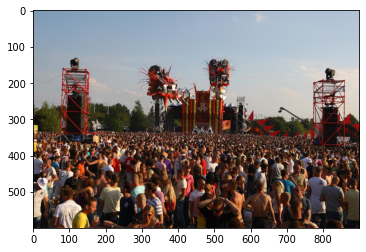

In [19]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[n]))

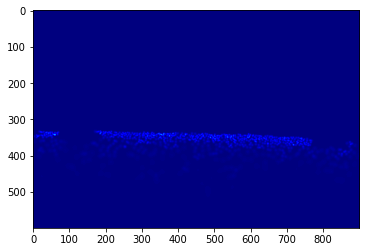

In [20]:
gt_file = h5py.File(img_paths[n].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [21]:
np.sum(groundtruth)

705.35095

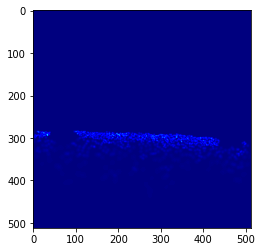

In [22]:
gt_file = h5py.File(img_paths[n].replace('.jpg','.h5').replace('images','new_gt'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [23]:
np.sum(groundtruth)# don't mind this slight variation

705.1902

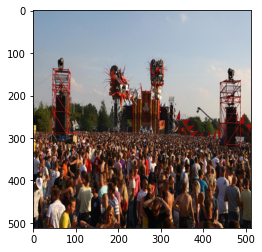

In [24]:
im = np.array(Image.open(img_paths[n]))
plt.imshow(cv2.resize(im, (512,512)))

In [7]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [8]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
        
print(img_paths)

['ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_1.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_10.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_100.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_101.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_102.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_103.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_104.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_105.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_106.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_107.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_108.jpg', 'ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images\\IMG_109.

In [8]:
for i, img_path in enumerate(img_paths):
    print(i, img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

0 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_1.jpg
1 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_10.jpg
2 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_100.jpg
3 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_101.jpg
4 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_102.jpg
5 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_103.jpg
6 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_104.jpg
7 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_105.jpg
8 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_106.jpg
9 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_107.jpg
10 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_108.jpg
11 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_109.jpg
12 ShanghaiTech_Crowd_Countin


KeyboardInterrupt



In [20]:
#FOR VITS
        
for i, img_path in enumerate(img_paths):
    print(i, img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    height, width = img.shape[0],img.shape[1]
    #resized fo vit
    
    img = cv2.resize(img, (512,512))
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1]/height*512)<img.shape[0] and int(gt[i][0]/width*512)<img.shape[1]:
            k[int(gt[i][1]/height*512),int(gt[i][0]/width*512)]=1
    k = gaussian_filter(k,15)
    #k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','new_gt'), 'w') as hf:
            hf['density'] = k

0 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_1.jpg
1 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_10.jpg
2 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_100.jpg
3 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_101.jpg
4 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_102.jpg
5 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_103.jpg
6 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_104.jpg
7 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_105.jpg
8 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_106.jpg
9 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_107.jpg
10 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_108.jpg
11 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_109.jpg
12 ShanghaiTech_Crowd_Countin

101 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_190.jpg
102 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_191.jpg
103 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_192.jpg
104 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_193.jpg
105 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_194.jpg
106 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_195.jpg
107 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_196.jpg
108 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_197.jpg
109 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_198.jpg
110 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_199.jpg
111 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_2.jpg
112 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_20.jpg
113 Sha

204 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_283.jpg
205 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_284.jpg
206 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_285.jpg
207 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_286.jpg
208 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_287.jpg
209 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_288.jpg
210 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_289.jpg
211 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_29.jpg
212 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_290.jpg
213 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_291.jpg
214 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_292.jpg
215 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_293.jpg
216 S

307 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_376.jpg
308 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_377.jpg
309 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_378.jpg
310 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_379.jpg
311 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_38.jpg
312 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_380.jpg
313 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_381.jpg
314 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_382.jpg
315 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_383.jpg
316 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_384.jpg
317 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_385.jpg
318 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\images\IMG_386.jpg
319 S

407 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_105.jpg
408 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_106.jpg
409 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_107.jpg
410 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_108.jpg
411 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_109.jpg
412 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_11.jpg
413 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_110.jpg
414 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_111.jpg
415 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_112.jpg
416 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_113.jpg
417 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_114.jpg
418 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_115.jpg
419 ShanghaiTech_

509 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_198.jpg
510 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_199.jpg
511 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_2.jpg
512 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_20.jpg
513 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_200.jpg
514 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_201.jpg
515 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_202.jpg
516 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_203.jpg
517 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_204.jpg
518 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_205.jpg
519 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_206.jpg
520 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_207.jpg
521 ShanghaiTech_Cr

611 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_29.jpg
612 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_290.jpg
613 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_291.jpg
614 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_292.jpg
615 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_293.jpg
616 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_294.jpg
617 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_295.jpg
618 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_296.jpg
619 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_297.jpg
620 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_298.jpg
621 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_299.jpg
622 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_3.jpg
623 ShanghaiTech_Cr

712 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_96.jpg
713 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_97.jpg
714 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_98.jpg
715 ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\images\IMG_99.jpg


In [23]:
#now see a sample from ShanghaiA
n=-1
#plt.imshow(Image.open(img_paths[n]))
mat = io.loadmat(img_paths[n].replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
gt = mat["image_info"][0,0][0,0][0]
print(len(gt))

113


112.99999999999994


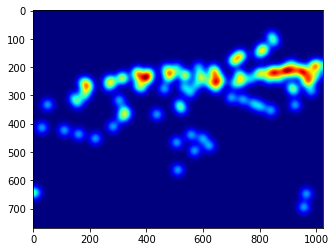

In [24]:
gt_file = h5py.File(img_paths[n].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

print(np.sum(groundtruth))

113.00000000000004


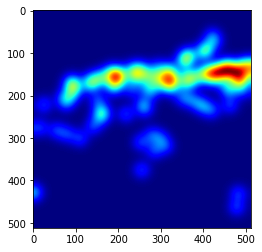

In [25]:
gt_file = h5py.File(img_paths[n].replace('.jpg','.h5').replace('images','new_gt'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

print(np.sum(groundtruth))